# Face Emotion Detection

#### We solve this problem by applying deep learning algorithms to live video data. The solution to this problem is by recognizing facial emotions. This is a few shot learning live face emotion detection system. The model should be able to real-time identify the emotions of students in a live class.

## Import Libraries

In [1]:
import sys, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.metrics import confusion_matrix,classification_report

from IPython.display import SVG, Image

In [2]:
df=pd.read_csv(r'C:\Users\shubhangi\github\Realtime face\fer2013.csv')

## Data Preprocessing

In [3]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [5]:
df['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [6]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [7]:
X_train,train_y,X_test,test_y=[],[],[],[]

In [8]:
for index, row in df.iterrows():
    val=row['pixels'].split(" ")
    try:
        if 'Training' in row['Usage']:
           X_train.append(np.array(val,'float32'))
           train_y.append(row['emotion'])
        elif 'PublicTest' in row['Usage']:
           X_test.append(np.array(val,'float32'))
           test_y.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")

In [9]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 30
width, height = 48, 48

In [10]:
X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

In [11]:
train_y=np_utils.to_categorical(train_y, num_classes=num_labels)
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)

In [12]:
#normalizing data between 0 and 1
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

In [13]:
X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

In [14]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

In [15]:
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [16]:
print(f"shape:{X_train.shape}")

shape:(28709, 48, 48, 1)


In [17]:
# Splitting into train test and validate

train_data = df[df["Usage"]=="Training"]
val_data = df[df["Usage"]=="PublicTest"]
test_data = df[df["Usage"]=="PrivateTest"]

print(train_data.shape,test_data.shape,val_data.shape)

(28709, 3) (3589, 3) (3589, 3)


In [18]:
# to extract image data from pixel column

def toPixels(pixels):

    arr = np.array(pixels.split(),"float64")
    return arr

def reshapetoImage(df):

    Images = np.reshape(df["pixels"].to_list(),(df.shape[0],48,48,1))

    return Images

In [19]:
train_data["pixels"] = train_data["pixels"].apply(toPixels)
val_data["pixels"] = val_data["pixels"].apply(toPixels)
test_data["pixels"] = test_data["pixels"].apply(toPixels)

<ipython-input-19-b3c9d7a8ee8f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["pixels"] = train_data["pixels"].apply(toPixels)
<ipython-input-19-b3c9d7a8ee8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data["pixels"] = val_data["pixels"].apply(toPixels)
<ipython-input-19-b3c9d7a8ee8f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [20]:
# images and labels

train_images = reshapetoImage(train_data)
val_images = reshapetoImage(val_data)
test_images = reshapetoImage(test_data)

train_labels = train_data["emotion"]
val_labels = val_data["emotion"]
test_labels = test_data["emotion"]

## Visualization of images

In [23]:
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

In [26]:
def plotImages(x,y):
    plt.figure(figsize=[20,12])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(x[i],cmap="gray")
        plt.title(emotions[y[i]])
        plt.axis("off")
    plt.show()

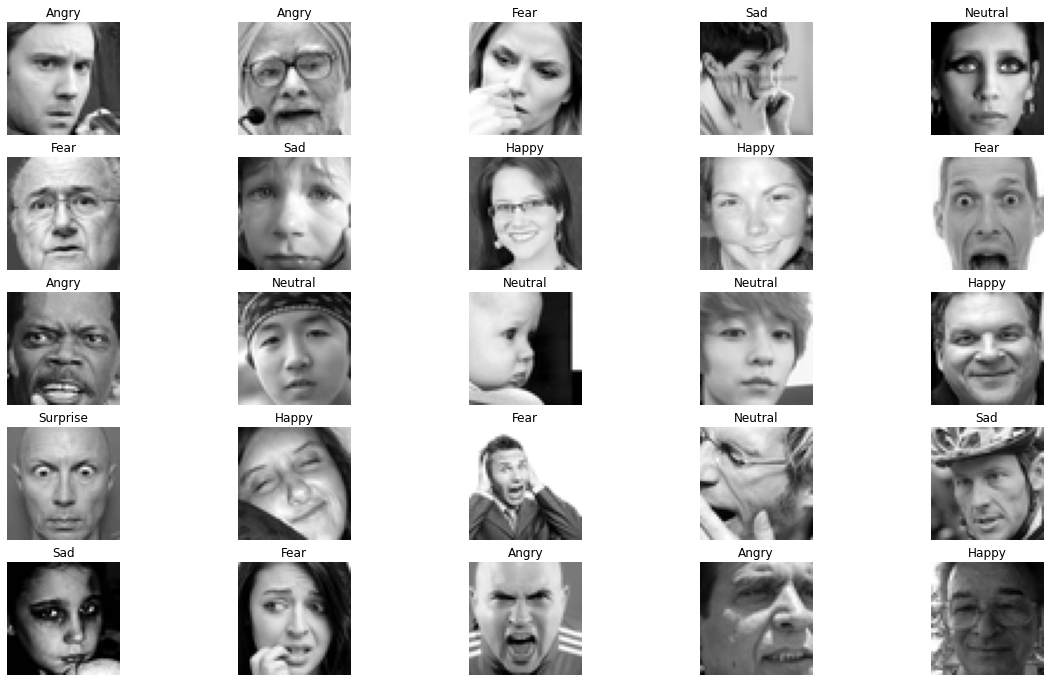

In [27]:
plotImages(train_images,train_labels)

## Image Data Generator

In [28]:
trainGen = Imgen(rescale=1./255,
                 zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip=True
                 )
valGen = Imgen(rescale=1./255,
                 zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip=True
               )
testGen = Imgen(rescale=1./255)

In [29]:
trainds = trainGen.flow(train_images,train_labels,
                   batch_size = 128
                   )

valds = valGen.flow(val_images,val_labels,
               batch_size = 128
               )

testds = testGen.flow(test_images,test_labels,
                      batch_size=128,
                      shuffle=False)

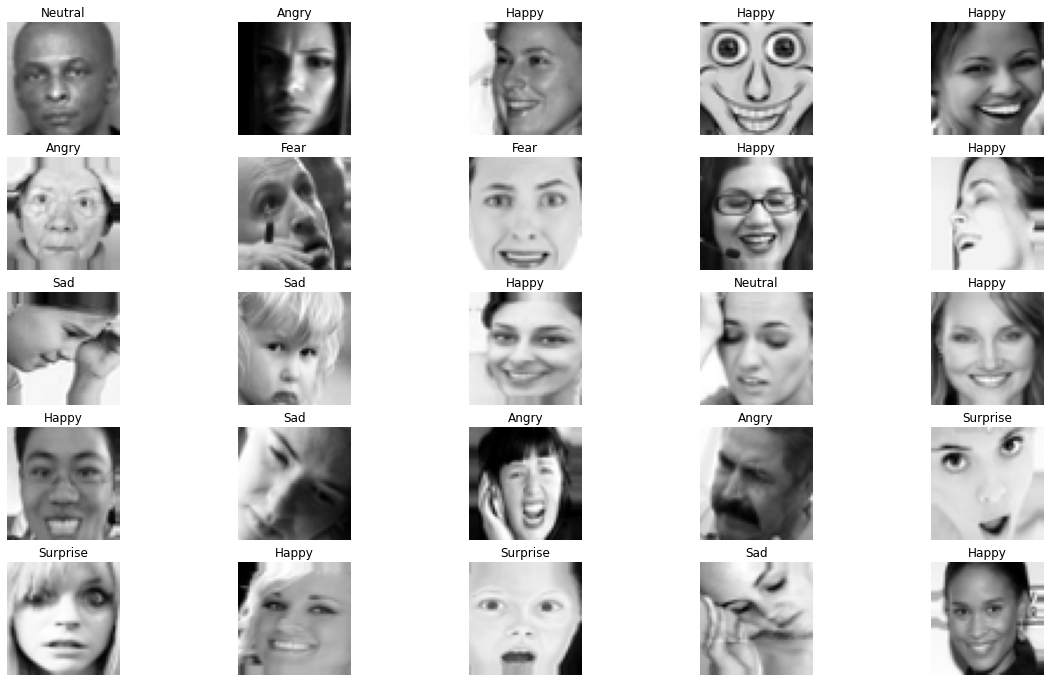

In [30]:
# one batch
x,y = next(trainds)

# see 
plotImages(x,y)

## Model

In [31]:
##designing the cnn
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5